# Clean Bibliography

To goal of this notebook is to clean your `.bib` file to ensure that it only contains the full first names of references that you have cited in your paper. The full first names will then be used to query the probabilistic gender classifier, [Gender API](https://gender-api.com) if over 100 names or [genderize.io](https://genderize.io) if under 100 names. The full names will be used to query for probabilistic race using the [ethnicolr package](https://ethnicolr.readthedocs.io/).

The only required file you need is your manuscript's bibliography in `.bib` format. __Your `.bib` must only contain references cited in the manuscript__. Otherwise, the estimated proportions will be inaccurate.

If you intend to analyze the reference list of a published paper instead of your own manuscript in progress, search the paper on [Web of Knowledge](http://apps.webofknowledge.com/) (you will need institutional access). Next, [download the .bib file from Web of Science following these instructions, but start from Step 4 and on Step 6 select BibTeX instead of Plain Text](https://github.com/jdwor/gendercitation/blob/master/Step0_PullingWOSdata.pdf).

If you are not using LaTeX, collect and organize only the references you have cited in your manuscript using your reference manager of choice (e.g. Mendeley, Zotero, EndNote, ReadCube, etc.) and export that selected bibliography as a `.bib` file. __Please try to export your .bib in an output style that uses full first names (rather than only first initials) and using the full author lists (rather than abbreviated author lists with "et al.").__ If first initials are included, our code will automatically retrieve about 70% of those names using the article title or DOI. 

   * [Export `.bib` from Mendeley](https://blog.mendeley.com/2011/10/25/howto-use-mendeley-to-create-citations-using-latex-and-bibtex/)
   * [Export `.bib` from Zotero](https://libguides.mit.edu/ld.php?content_id=34248570)
   * [Export `.bib` from EndNote](https://www.reed.edu/cis/help/LaTeX/EndNote.html). Note: Please export full first names by either [choosing an output style that does so by default (e.g. in MLA style)](https://canterbury.libguides.com/endnote/basics-output) or by [customizing an output style.](http://bibliotek.usn.no/cite-and-write/endnote/how-to-use/how-to-show-the-author-s-full-name-in-the-reference-list-article185897-28181.html)
   * [Export `.bib` from Read Cube Papers](https://support.papersapp.com/support/solutions/articles/30000024634-how-can-i-export-references-from-readcube-papers-)

For those working in LaTeX, we can use an optional `.aux` file to automatically filter your `.bib` to check that it only contains entries which are cited in your manuscript.

| Input                 | Output                                                                                                                        |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------|
| `.bib` file(s)**(REQUIRED)**    | `cleanBib.csv`: table of author first names, titles, and .bib keys                                                            |
| `.aux` file (OPTIONAL)| `predictions.csv`: table of author first names, estimated gender classification, and confidence                                   |
| `.tex` file (OPTIONAL) | `race_gender_citations.pdf`: heat map of your citations broken down by probabilistic gender and race estimations
|                       | `yourTexFile_gendercolor.tex`: your `.tex` file modified to compile .pdf with in-line citations colored-coded by gender pairs |

## 1. Import functions

Upload your `.bib` file(s) and _optionally_ an `.aux` file generated from compiling your LaTeX manuscript and your `.tex` file

![upload button](img/upload.png)

![confirm upload button](img/confirmUpload.png)

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [2]:
# %load_ext autoreload
# %autoreload 2
# automatically reloads modules..not sure we need

import glob
from habanero import Crossref
import sys
import os
from pathlib import Path
wd = Path(os.getcwd())
#sys.path.insert(1, f'{wd.absolute()}/utils')
from preprocessing import *
from ethnicolr import pred_fl_reg_name
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

cr = Crossref()
homedir = '' #'/home/jovyan/'
bib_files = glob.glob(homedir + '*.bib')
paper_aux_file = glob.glob(homedir + '*.aux')
paper_bib_file = 'library_paper.bib'
try:
    tex_file = glob.glob(homedir + "*.tex")[0]
except:
    print('No optional .tex file found.')
if len(bib_files) == 0:
    print("No .bib file found.")

2024-09-16 19:23:53.954222: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 19:23:54.020665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 19:23:54.020695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 19:23:54.022539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 19:23:54.033156: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 19:23:54.034101: I tensorflow/core/platform/cpu_feature_guard.cc:1

No optional .tex file found.


In [4]:
print(bib_files)
print(paper_aux_file)
# including second aux file caused confusion so leaving out

['final.bib']
['contact.aux']


### 2. Define the _first_ and _last_ author of your paper.

For example: 
```
yourFirstAuthor = 'Teich, Erin G.'
yourLastAuthor = 'Bassett, Danielle S.'
```

And optionally, define any co-first or co-last author(s), making sure to keep the square brackets to define a list.

For example:
```
optionalEqualContributors = ['Dworkin, Jordan', 'Stiso, Jennifer']
```

or 

```
optionalEqualContributors = ['Dworkin, Jordan']
```

If you are analyzing published papers' reference lists from Web of Science, change the variable checkingPublishedArticle to True:
```
checkingPublishedArticle = True
```

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

__NOTE__: Please edit your .bib file using information printed by the code and provided in cleanedBib.csv. Edit directly within the Binder environment by clicking the .bib file (as shown below), making modifications, and saving the file (as shown below).

![open button](img/openBib.png)

![save button](img/saveBib.png)

Common issues include:

* Bibliography entry did not include a last author because the author list was truncated by "and Others" or "et al."
* Some older journals articles only provide first initial and not full first names, in which case you will need to go digging via Google to identify that person.
* In rare cases where the author cannot be identified even after searching by hand, replace the first name with "UNKNOWNNAMES" so that the classifier will estimate the gender as unknown.
* Make sure groups aren't used as first or last authors

In [9]:
yourFirstAuthor = 'LastName, FirstName OptionalMiddleInitial'
yourLastAuthor = 'LastName, FirstName OptionalMiddleInitial'
optionalEqualContributors = ['LastName, FirstName OptionalMiddleInitial', 'LastName, FirstName OptionalMiddleInitial']
checkingPublishedArticle = False

if paper_aux_file:
    unused_keys = [find_unused_cites([file]) for file in paper_aux_file]
    unused_keys = [item for sublist in unused_keys for item in sublist] # this is just concatenating lists into one I think
else:
    unused_keys = None
# why are my refs in second aux file being included when they are used but undefined?

     _           _       _ _
 ___| |_ ___ ___| |_ ___|_| |_ ___ ___
|  _|   | -_|  _| '_|  _| |  _| -_|_ -|
|___|_|_|___|___|_,_|___|_|_| |___|___|

checkcites.lua -- a reference checker script (v2.4)
Copyright (c) 2012, 2019, Enrico Gregorio, Paulo Roberto Massa Cereda

could not be resolved at runtime:
=> supp.aux

Great, I found 43 citations in 1 file. I also found 1 bibliography file.
Let me check this file and extract the references. Please wait a moment.

Fantastic, I found 69 references in 1 bibliography file. Please wait a
moment while the reports are generated.

--------------------------------------------------------------------------
Report of unused references in your TeX document (that is, references
present in bibliography files, but not cited in the TeX source file)
--------------------------------------------------------------------------

Unused references in your TeX document: 28
=> bansal_comparative_2006
=> bansal_impact_2012
=> bansal_shifting_2010
=> bilinski_bett

### The unused references mentioned above from your .bib file have been removed for the remainder of the code

In [11]:
# parses bib file
bib_data = get_bib_data(bib_files[0])
if checkingPublishedArticle:
    get_names_published(homedir, bib_data, cr)
else:
    # find and print duplicates
    bib_data = get_duplicates(bib_data, bib_files[0])
    # get names, remove CDS, find self cites
    group_authors = get_names(homedir, bib_data, yourFirstAuthor, yourLastAuthor, optionalEqualContributors, cr, unused_keys)
    
bib_check(homedir, group_authors)

1: aleta_modelling_2020
2: bansal_when_2007  <-- self-citation
3: bharti_explaining_2011
4: breen_novel_2022
5: cmmid_covid-19_working_group_quantifying_2020
6: coletti_comix_2020
7: destefano_factors_2011
8: dorelien_analyzing_2021
9: dorelien_quantifying_2023
10: favier_influence_2005
11: feehan_quantifying_2021
12: garnier_socioeconomic_2021  <-- self-citation
13: gimma_changes_2022
14: gostic_practical_2020
15: hale_global_2021
16: ingram_2013_2014
17: kiti_quantifying_2014
18: klein_characterizing_2024
19: kleynhans_cross-sectional_2021
20: kretzschmar_impact_2020
21: kummer_evaluating_2022
22: lloyd-smith_superspreading_2005
23: mistry_inferring_2021
24: mossong_social_2008
25: mousa_social_2021
26: munday_evaluating_2023
27: nelson_nationally_2022
28: overton_using_2020
29: pedersen_hierarchical_2019
30: pullano_characterizing_2024  <-- self-citation
31: read_social_2014
32: rohani_contact_2010
33: salomon_us_2021
34: susswein_disentangling_2023  <-- self-citation
35: susswein_i

## 3. Estimate gender and race of authors from cleaned bibliography

### Checkpoint for cleaned bibliography and estimating genders and race by names
After registering for a [gender-api](https://gender-api.com/) account (free), use your 500 free monthly search credits by __pasting your API key in the code for the line indicated below__ (replace only YOUR ACCOUNT KEY HERE):

```genderAPI_key = '&key=YOUR ACCOUNT KEY HERE'```

[You can find your key in your account's profile page.](https://gender-api.com/en/account/overview#my-api-key)

Then, run the code blocks below to estimate how many credits we will need to use. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar) Run this even if your bibliography is small enough to use genderize.io.

In [13]:
# moot because we are using different gender prediction software
genderAPI_key = '&key=YOUR ACCOUNT KEY HERE'

# # Check your credit balance
check_genderAPI_balance(genderAPI_key, homedir)

Remaining credits: 497
This should use (at most) 64 credits, saving you approx 4 credit(s) by storing queries.


## 4. Describe the proportions of genders in your reference list and compare it to published base rates in infectious disease dynamics.

__NOTE__: your free GenderAPI account has 500 queries per month and genderize.io has 100 free queries per day. This box contains the code that will use your limited API credits/queries if it runs without error. Re-running all code repeatedly will repeatedly use these credits.

Run the code blocks below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [15]:
# if your bibliography is small enough for genderize.io but you still want to use genderAPI, then set no_credits_left = True
mm, wm, mw, ww, WW, pw, wp, pp, citation_matrix, paper_df = get_pred_demos((yourFirstAuthor+' '+yourLastAuthor).replace(',',''), homedir, bib_data, 
                                                                           genderAPI_key, unused_keys, identity_threshold = 0.7, no_credits_left = True)


first author is Juliana Taube 
last author is Shweta Bansal 
we don't count these, but check the predictions file to ensure your names did not slip through!
looping through your references, predicting gender and race
using genderAPI for gender inference due to bibliography size


  0%|          | 0/41 [00:00<?, ?it/s]

Yamir


  2%|▏         | 1/41 [00:01<00:54,  1.36s/it]

Bryan


  7%|▋         | 3/41 [00:02<00:27,  1.39it/s]

Dennis


 10%|▉         | 4/41 [00:03<00:30,  1.22it/s]

John


 12%|█▏        | 5/41 [00:04<00:31,  1.14it/s]

Niel


 15%|█▍        | 6/41 [00:05<00:32,  1.08it/s]

Scott


 17%|█▋        | 7/41 [00:06<00:32,  1.05it/s]

Rachelle


 20%|█▉        | 8/41 [00:07<00:33,  1.01s/it]

Shalini


 22%|██▏       | 9/41 [00:08<00:27,  1.17it/s]

Marc


 24%|██▍       | 10/41 [00:09<00:28,  1.10it/s]

Ayesha


 32%|███▏      | 13/41 [00:10<00:15,  1.79it/s]

Sarah


 34%|███▍      | 14/41 [00:11<00:19,  1.36it/s]

Helen


 37%|███▋      | 15/41 [00:12<00:22,  1.15it/s]

Sheila


 39%|███▉      | 16/41 [00:13<00:23,  1.07it/s]

David


 41%|████▏     | 17/41 [00:14<00:23,  1.04it/s]

Matteo


 44%|████▍     | 18/41 [00:15<00:22,  1.03it/s]

Stuart


 49%|████▉     | 20/41 [00:17<00:18,  1.13it/s]

Marco


 51%|█████     | 21/41 [00:18<00:18,  1.09it/s]

Wayne


 54%|█████▎    | 22/41 [00:19<00:17,  1.06it/s]

Alessandro


 59%|█████▊    | 24/41 [00:20<00:14,  1.20it/s]

Charles


 61%|██████    | 25/41 [00:21<00:14,  1.14it/s]

Sebastian


 63%|██████▎   | 26/41 [00:22<00:13,  1.15it/s]

Benjamin


 66%|██████▌   | 27/41 [00:23<00:12,  1.10it/s]

Luke


 68%|██████▊   | 28/41 [00:24<00:10,  1.20it/s]

Noam


 71%|███████   | 29/41 [00:25<00:10,  1.14it/s]

Derek


 76%|███████▌  | 31/41 [00:26<00:07,  1.40it/s]

Aaron


 78%|███████▊  | 32/41 [00:27<00:07,  1.25it/s]

Ryan


 80%|████████  | 33/41 [00:28<00:07,  1.14it/s]

Justin


 98%|█████████▊| 40/41 [00:30<00:00,  2.10it/s]

Christina


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]

Queried gender api 59 times out of 138 entries
Queried race/ethnicity api 62 times out of 138 entries
MM: 48.294117647058826 WM: 31.11764705882353 MW: 5.88235294117647 WW: 14.705882352941178
WhWh: 57.390708265387836 PoCWh: 16.686926425148773 WhPoC: 17.25308627130035 PoCPoC: 8.669278820879004


## 5. Visualize your results

### Additional info about the IDD benchmark
ADD THIS

This box does NOT contain code that will use your limited API credits/queries.

Run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

  RaceCat   0
0      PP   1
1      WP   1
2      PW   3
3      WW  19


/home/a7a1ec6b-7fff-4e65-99fe-e5ea87baf016/queries.py:531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_for_baserate_plot = dat_for_baserate_plot.astype({"count": int})


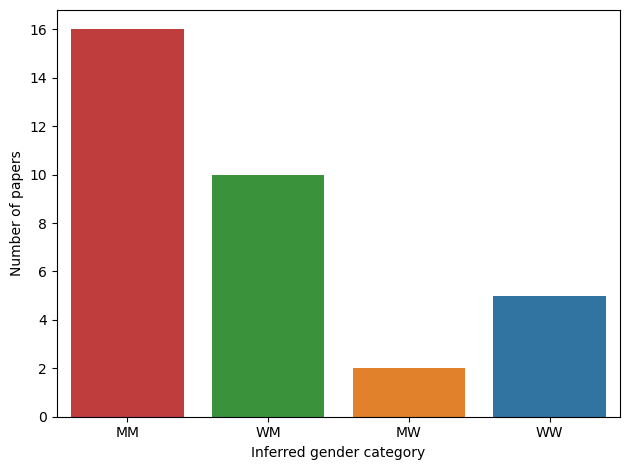

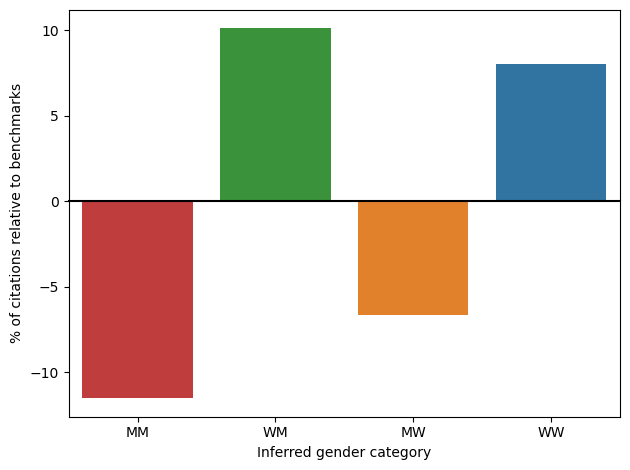

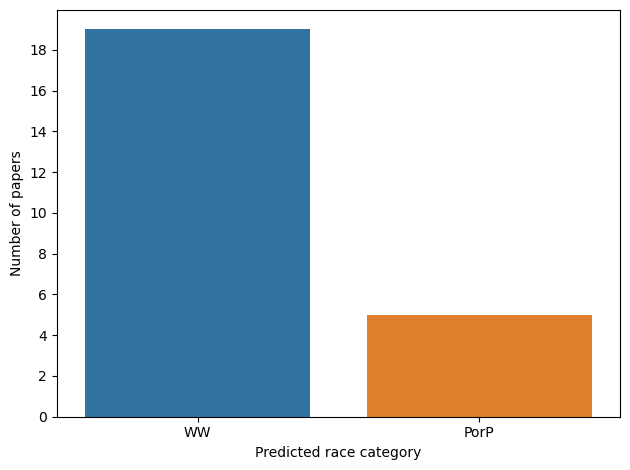

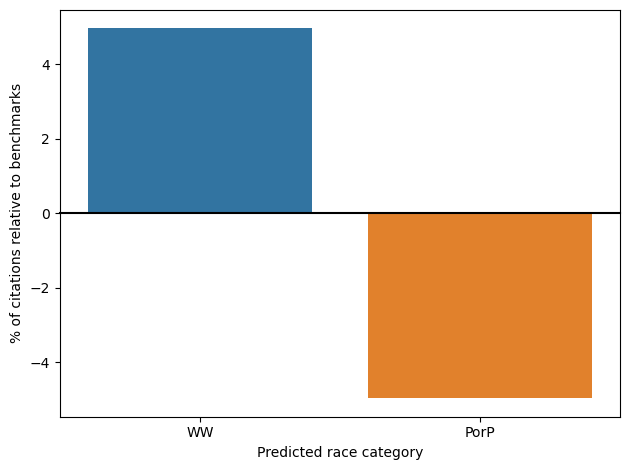

In [19]:
paper_df.to_csv('predictions.csv')

plot_gender_histograms()
plot_race_histograms()